In [1]:
#IMPORTS

#File IO
import os
import glob

#Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
from segmentation_models_pytorch import Unet

#Scikit learn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

#Misc
from tqdm import tqdm


In [2]:
#HYPERPARMETERS

train_proportion = .8
val_proportion = .1

batch_size = 128
learning_rate = .00002
num_epochs = 100

In [3]:
#CREATE DATASET

dataset = torch.load("phase_unet_dataset.pt", weights_only=False)

In [4]:
#CREATE DATALOADERS

train_size = int(train_proportion * len(dataset))
val_size = int(val_proportion * len(dataset))
test_size = len(dataset) - train_size - val_size

generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
#CREATE MODEL

num_classes = 5
model = Unet(
    encoder_name="resnet34",
    in_channels=16,
    classes=num_classes
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
model = model.to(device)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [6]:
#TRAIN and EVALUATE FUNCTIONS

def train(model, train_loader):
    model.train()
    train_loss = correct = total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (preds == labels).sum().item()
        total += labels.numel()

    #total is number of train instances
    avg_loss = train_loss/len(train_loader)
    accuracy = correct/total
    return avg_loss, accuracy

def eval(model, val_loader):
    model.eval()
    val_loss = correct = total = 0

    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        loss = criterion(outputs, labels)

        val_loss += loss.item()
        correct += (preds == labels).sum().item()
        total += labels.numel()

    avg_loss = val_loss/len(val_loader)
    accuracy = correct/total
    return avg_loss, accuracy

In [7]:
#TRAIN MODEL

for e in range(1, num_epochs+1):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = eval(model, val_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch: {e} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

100%|██████████| 94/94 [00:17<00:00,  5.28it/s]


Epoch: 1 | Train Loss: 1.4387 | Train Acc: 0.3927 | Val Loss: 1.2922 | Val Acc: 0.5054


100%|██████████| 94/94 [00:12<00:00,  7.45it/s]


Epoch: 2 | Train Loss: 1.1514 | Train Acc: 0.6124 | Val Loss: 1.1059 | Val Acc: 0.6531


100%|██████████| 94/94 [00:12<00:00,  7.64it/s]


Epoch: 3 | Train Loss: 0.9660 | Train Acc: 0.7148 | Val Loss: 0.9141 | Val Acc: 0.7307


100%|██████████| 94/94 [00:11<00:00,  8.04it/s]


Epoch: 4 | Train Loss: 0.8336 | Train Acc: 0.7620 | Val Loss: 0.8250 | Val Acc: 0.7625


100%|██████████| 94/94 [00:12<00:00,  7.41it/s]


Epoch: 5 | Train Loss: 0.7359 | Train Acc: 0.7888 | Val Loss: 0.7795 | Val Acc: 0.7523


100%|██████████| 94/94 [00:12<00:00,  7.49it/s]


Epoch: 6 | Train Loss: 0.6705 | Train Acc: 0.8049 | Val Loss: 0.7379 | Val Acc: 0.7728


100%|██████████| 94/94 [00:12<00:00,  7.41it/s]


Epoch: 7 | Train Loss: 0.6267 | Train Acc: 0.8137 | Val Loss: 0.6317 | Val Acc: 0.8042


100%|██████████| 94/94 [00:13<00:00,  7.16it/s]


Epoch: 8 | Train Loss: 0.5875 | Train Acc: 0.8223 | Val Loss: 0.6913 | Val Acc: 0.7723


100%|██████████| 94/94 [00:13<00:00,  7.09it/s]


Epoch: 9 | Train Loss: 0.5581 | Train Acc: 0.8281 | Val Loss: 0.5692 | Val Acc: 0.8189


100%|██████████| 94/94 [00:11<00:00,  7.97it/s]


Epoch: 10 | Train Loss: 0.5289 | Train Acc: 0.8349 | Val Loss: 0.5460 | Val Acc: 0.8247


100%|██████████| 94/94 [00:11<00:00,  8.08it/s]


Epoch: 11 | Train Loss: 0.5037 | Train Acc: 0.8409 | Val Loss: 0.5798 | Val Acc: 0.8140


100%|██████████| 94/94 [00:12<00:00,  7.66it/s]


Epoch: 12 | Train Loss: 0.4879 | Train Acc: 0.8434 | Val Loss: 0.6569 | Val Acc: 0.7749


100%|██████████| 94/94 [00:13<00:00,  7.09it/s]


Epoch: 13 | Train Loss: 0.4691 | Train Acc: 0.8477 | Val Loss: 0.5027 | Val Acc: 0.8325


100%|██████████| 94/94 [00:12<00:00,  7.52it/s]


Epoch: 14 | Train Loss: 0.4517 | Train Acc: 0.8520 | Val Loss: 0.5085 | Val Acc: 0.8300


100%|██████████| 94/94 [00:11<00:00,  8.07it/s]


Epoch: 15 | Train Loss: 0.4385 | Train Acc: 0.8545 | Val Loss: 0.4947 | Val Acc: 0.8314


100%|██████████| 94/94 [00:12<00:00,  7.75it/s]


Epoch: 16 | Train Loss: 0.4238 | Train Acc: 0.8587 | Val Loss: 0.4914 | Val Acc: 0.8326


100%|██████████| 94/94 [00:13<00:00,  7.16it/s]


Epoch: 17 | Train Loss: 0.4137 | Train Acc: 0.8607 | Val Loss: 0.4712 | Val Acc: 0.8345


100%|██████████| 94/94 [00:13<00:00,  7.18it/s]


Epoch: 18 | Train Loss: 0.4059 | Train Acc: 0.8623 | Val Loss: 0.4578 | Val Acc: 0.8404


100%|██████████| 94/94 [00:13<00:00,  7.07it/s]


Epoch: 19 | Train Loss: 0.3935 | Train Acc: 0.8659 | Val Loss: 0.4610 | Val Acc: 0.8392


100%|██████████| 94/94 [00:12<00:00,  7.33it/s]


Epoch: 20 | Train Loss: 0.3865 | Train Acc: 0.8674 | Val Loss: 0.4507 | Val Acc: 0.8406


100%|██████████| 94/94 [00:13<00:00,  7.06it/s]


Epoch: 21 | Train Loss: 0.3798 | Train Acc: 0.8686 | Val Loss: 0.5342 | Val Acc: 0.8115


100%|██████████| 94/94 [00:12<00:00,  7.44it/s]


Epoch: 22 | Train Loss: 0.3717 | Train Acc: 0.8705 | Val Loss: 0.4438 | Val Acc: 0.8430


100%|██████████| 94/94 [00:13<00:00,  7.01it/s]


Epoch: 23 | Train Loss: 0.3621 | Train Acc: 0.8736 | Val Loss: 0.4295 | Val Acc: 0.8473


100%|██████████| 94/94 [00:13<00:00,  7.13it/s]


Epoch: 24 | Train Loss: 0.3581 | Train Acc: 0.8743 | Val Loss: 0.4820 | Val Acc: 0.8246


100%|██████████| 94/94 [00:13<00:00,  7.06it/s]


Epoch: 25 | Train Loss: 0.3513 | Train Acc: 0.8759 | Val Loss: 0.4285 | Val Acc: 0.8475


100%|██████████| 94/94 [00:12<00:00,  7.25it/s]


Epoch: 26 | Train Loss: 0.3470 | Train Acc: 0.8770 | Val Loss: 0.4504 | Val Acc: 0.8396


100%|██████████| 94/94 [00:13<00:00,  7.06it/s]


Epoch: 27 | Train Loss: 0.3399 | Train Acc: 0.8791 | Val Loss: 0.4182 | Val Acc: 0.8492


100%|██████████| 94/94 [00:13<00:00,  7.16it/s]


Epoch: 28 | Train Loss: 0.3360 | Train Acc: 0.8801 | Val Loss: 0.4895 | Val Acc: 0.8287


100%|██████████| 94/94 [00:11<00:00,  8.06it/s]


Epoch: 29 | Train Loss: 0.3318 | Train Acc: 0.8811 | Val Loss: 0.4049 | Val Acc: 0.8529


100%|██████████| 94/94 [00:11<00:00,  7.95it/s]


Epoch: 30 | Train Loss: 0.3285 | Train Acc: 0.8818 | Val Loss: 0.4487 | Val Acc: 0.8398


100%|██████████| 94/94 [00:13<00:00,  7.15it/s]


Epoch: 31 | Train Loss: 0.3196 | Train Acc: 0.8848 | Val Loss: 0.4633 | Val Acc: 0.8278


100%|██████████| 94/94 [00:12<00:00,  7.40it/s]


Epoch: 32 | Train Loss: 0.3162 | Train Acc: 0.8855 | Val Loss: 0.4208 | Val Acc: 0.8467


100%|██████████| 94/94 [00:12<00:00,  7.30it/s]


Epoch: 33 | Train Loss: 0.3122 | Train Acc: 0.8865 | Val Loss: 0.4356 | Val Acc: 0.8424


100%|██████████| 94/94 [00:12<00:00,  7.70it/s]


Epoch: 34 | Train Loss: 0.3104 | Train Acc: 0.8869 | Val Loss: 0.4553 | Val Acc: 0.8312


100%|██████████| 94/94 [00:13<00:00,  7.19it/s]


Epoch: 35 | Train Loss: 0.3090 | Train Acc: 0.8871 | Val Loss: 0.4096 | Val Acc: 0.8494


100%|██████████| 94/94 [00:12<00:00,  7.79it/s]


Epoch: 36 | Train Loss: 0.3075 | Train Acc: 0.8872 | Val Loss: 0.4206 | Val Acc: 0.8480


100%|██████████| 94/94 [00:13<00:00,  7.17it/s]


Epoch: 37 | Train Loss: 0.2990 | Train Acc: 0.8901 | Val Loss: 0.4598 | Val Acc: 0.8323


100%|██████████| 94/94 [00:11<00:00,  7.94it/s]


Epoch: 38 | Train Loss: 0.2959 | Train Acc: 0.8909 | Val Loss: 0.4158 | Val Acc: 0.8479


100%|██████████| 94/94 [00:12<00:00,  7.34it/s]


Epoch: 39 | Train Loss: 0.2940 | Train Acc: 0.8915 | Val Loss: 0.3924 | Val Acc: 0.8555


100%|██████████| 94/94 [00:12<00:00,  7.61it/s]


Epoch: 40 | Train Loss: 0.2921 | Train Acc: 0.8918 | Val Loss: 0.4638 | Val Acc: 0.8291


100%|██████████| 94/94 [00:11<00:00,  7.94it/s]


Epoch: 41 | Train Loss: 0.2899 | Train Acc: 0.8924 | Val Loss: 0.3914 | Val Acc: 0.8560


100%|██████████| 94/94 [00:13<00:00,  7.21it/s]


Epoch: 42 | Train Loss: 0.2872 | Train Acc: 0.8932 | Val Loss: 0.4151 | Val Acc: 0.8506


100%|██████████| 94/94 [00:12<00:00,  7.56it/s]


Epoch: 43 | Train Loss: 0.2871 | Train Acc: 0.8930 | Val Loss: 0.4192 | Val Acc: 0.8459


100%|██████████| 94/94 [00:13<00:00,  6.82it/s]


Epoch: 44 | Train Loss: 0.2825 | Train Acc: 0.8946 | Val Loss: 0.3838 | Val Acc: 0.8582


100%|██████████| 94/94 [00:13<00:00,  7.06it/s]


Epoch: 45 | Train Loss: 0.2791 | Train Acc: 0.8957 | Val Loss: 0.3909 | Val Acc: 0.8553


100%|██████████| 94/94 [00:12<00:00,  7.41it/s]


Epoch: 46 | Train Loss: 0.2771 | Train Acc: 0.8962 | Val Loss: 0.3934 | Val Acc: 0.8570


100%|██████████| 94/94 [00:11<00:00,  7.96it/s]


Epoch: 47 | Train Loss: 0.2740 | Train Acc: 0.8972 | Val Loss: 0.3918 | Val Acc: 0.8557


100%|██████████| 94/94 [00:12<00:00,  7.78it/s]


Epoch: 48 | Train Loss: 0.2697 | Train Acc: 0.8987 | Val Loss: 0.3894 | Val Acc: 0.8586


100%|██████████| 94/94 [00:13<00:00,  7.16it/s]


Epoch: 49 | Train Loss: 0.2695 | Train Acc: 0.8986 | Val Loss: 0.3980 | Val Acc: 0.8540


100%|██████████| 94/94 [00:12<00:00,  7.68it/s]


Epoch: 50 | Train Loss: 0.2674 | Train Acc: 0.8992 | Val Loss: 0.3922 | Val Acc: 0.8554


100%|██████████| 94/94 [00:13<00:00,  7.17it/s]


Epoch: 51 | Train Loss: 0.2645 | Train Acc: 0.9002 | Val Loss: 0.4650 | Val Acc: 0.8270


100%|██████████| 94/94 [00:12<00:00,  7.79it/s]


Epoch: 52 | Train Loss: 0.2669 | Train Acc: 0.8991 | Val Loss: 0.4482 | Val Acc: 0.8382


100%|██████████| 94/94 [00:13<00:00,  7.16it/s]


Epoch: 53 | Train Loss: 0.2653 | Train Acc: 0.8995 | Val Loss: 0.4136 | Val Acc: 0.8508


100%|██████████| 94/94 [00:12<00:00,  7.59it/s]


Epoch: 54 | Train Loss: 0.2597 | Train Acc: 0.9015 | Val Loss: 0.3777 | Val Acc: 0.8618


100%|██████████| 94/94 [00:12<00:00,  7.25it/s]


Epoch: 55 | Train Loss: 0.2610 | Train Acc: 0.9009 | Val Loss: 0.5209 | Val Acc: 0.8170


100%|██████████| 94/94 [00:12<00:00,  7.55it/s]


Epoch: 56 | Train Loss: 0.2589 | Train Acc: 0.9016 | Val Loss: 0.4254 | Val Acc: 0.8429


100%|██████████| 94/94 [00:12<00:00,  7.26it/s]


Epoch: 57 | Train Loss: 0.2559 | Train Acc: 0.9027 | Val Loss: 0.4466 | Val Acc: 0.8463


100%|██████████| 94/94 [00:12<00:00,  7.28it/s]


Epoch: 58 | Train Loss: 0.2519 | Train Acc: 0.9041 | Val Loss: 0.3732 | Val Acc: 0.8624


100%|██████████| 94/94 [00:12<00:00,  7.38it/s]


Epoch: 59 | Train Loss: 0.2540 | Train Acc: 0.9032 | Val Loss: 0.4054 | Val Acc: 0.8517


100%|██████████| 94/94 [00:13<00:00,  7.13it/s]


Epoch: 60 | Train Loss: 0.2522 | Train Acc: 0.9037 | Val Loss: 0.3894 | Val Acc: 0.8610


100%|██████████| 94/94 [00:12<00:00,  7.50it/s]


Epoch: 61 | Train Loss: 0.2501 | Train Acc: 0.9044 | Val Loss: 0.4022 | Val Acc: 0.8525


100%|██████████| 94/94 [00:12<00:00,  7.42it/s]


Epoch: 62 | Train Loss: 0.2482 | Train Acc: 0.9051 | Val Loss: 0.3792 | Val Acc: 0.8630


100%|██████████| 94/94 [00:12<00:00,  7.33it/s]


Epoch: 63 | Train Loss: 0.2475 | Train Acc: 0.9052 | Val Loss: 0.3835 | Val Acc: 0.8579


100%|██████████| 94/94 [00:12<00:00,  7.54it/s]


Epoch: 64 | Train Loss: 0.2462 | Train Acc: 0.9057 | Val Loss: 0.4394 | Val Acc: 0.8408


100%|██████████| 94/94 [00:13<00:00,  7.23it/s]


Epoch: 65 | Train Loss: 0.2468 | Train Acc: 0.9054 | Val Loss: 0.4654 | Val Acc: 0.8287


100%|██████████| 94/94 [00:12<00:00,  7.60it/s]


Epoch: 66 | Train Loss: 0.2452 | Train Acc: 0.9058 | Val Loss: 0.4054 | Val Acc: 0.8539


100%|██████████| 94/94 [00:13<00:00,  7.18it/s]


Epoch: 67 | Train Loss: 0.2410 | Train Acc: 0.9074 | Val Loss: 0.3773 | Val Acc: 0.8638


100%|██████████| 94/94 [00:12<00:00,  7.67it/s]


Epoch: 68 | Train Loss: 0.2417 | Train Acc: 0.9071 | Val Loss: 0.3640 | Val Acc: 0.8645


100%|██████████| 94/94 [00:13<00:00,  7.02it/s]


Epoch: 69 | Train Loss: 0.2408 | Train Acc: 0.9074 | Val Loss: 0.3972 | Val Acc: 0.8533


100%|██████████| 94/94 [00:12<00:00,  7.48it/s]


Epoch: 70 | Train Loss: 0.2372 | Train Acc: 0.9086 | Val Loss: 0.3769 | Val Acc: 0.8646


100%|██████████| 94/94 [00:12<00:00,  7.25it/s]


Epoch: 71 | Train Loss: 0.2378 | Train Acc: 0.9084 | Val Loss: 0.3901 | Val Acc: 0.8558


100%|██████████| 94/94 [00:12<00:00,  7.77it/s]


Epoch: 72 | Train Loss: 0.2372 | Train Acc: 0.9085 | Val Loss: 0.4082 | Val Acc: 0.8504


100%|██████████| 94/94 [00:12<00:00,  7.29it/s]


Epoch: 73 | Train Loss: 0.2362 | Train Acc: 0.9090 | Val Loss: 0.3878 | Val Acc: 0.8563


100%|██████████| 94/94 [00:12<00:00,  7.51it/s]


Epoch: 74 | Train Loss: 0.2344 | Train Acc: 0.9095 | Val Loss: 0.4099 | Val Acc: 0.8581


100%|██████████| 94/94 [00:12<00:00,  7.27it/s]


Epoch: 75 | Train Loss: 0.2317 | Train Acc: 0.9106 | Val Loss: 0.5933 | Val Acc: 0.8233


100%|██████████| 94/94 [00:12<00:00,  7.54it/s]


Epoch: 76 | Train Loss: 0.2310 | Train Acc: 0.9107 | Val Loss: 0.3642 | Val Acc: 0.8677


100%|██████████| 94/94 [00:12<00:00,  7.33it/s]


Epoch: 77 | Train Loss: 0.2297 | Train Acc: 0.9111 | Val Loss: 0.4297 | Val Acc: 0.8428


100%|██████████| 94/94 [00:12<00:00,  7.64it/s]


Epoch: 78 | Train Loss: 0.2314 | Train Acc: 0.9104 | Val Loss: 0.4145 | Val Acc: 0.8536


100%|██████████| 94/94 [00:12<00:00,  7.30it/s]


Epoch: 79 | Train Loss: 0.2304 | Train Acc: 0.9107 | Val Loss: 0.3622 | Val Acc: 0.8661


100%|██████████| 94/94 [00:12<00:00,  7.79it/s]


Epoch: 80 | Train Loss: 0.2263 | Train Acc: 0.9123 | Val Loss: 0.3614 | Val Acc: 0.8671


100%|██████████| 94/94 [00:12<00:00,  7.32it/s]


Epoch: 81 | Train Loss: 0.2248 | Train Acc: 0.9129 | Val Loss: 0.3947 | Val Acc: 0.8624


100%|██████████| 94/94 [00:11<00:00,  8.06it/s]


Epoch: 82 | Train Loss: 0.2257 | Train Acc: 0.9123 | Val Loss: 0.3921 | Val Acc: 0.8565


100%|██████████| 94/94 [00:11<00:00,  8.10it/s]


Epoch: 83 | Train Loss: 0.2250 | Train Acc: 0.9125 | Val Loss: 0.3719 | Val Acc: 0.8633


100%|██████████| 94/94 [00:11<00:00,  8.15it/s]


Epoch: 84 | Train Loss: 0.2229 | Train Acc: 0.9134 | Val Loss: 0.4026 | Val Acc: 0.8565


100%|██████████| 94/94 [00:11<00:00,  8.13it/s]


Epoch: 85 | Train Loss: 0.2230 | Train Acc: 0.9133 | Val Loss: 0.3730 | Val Acc: 0.8662


100%|██████████| 94/94 [00:11<00:00,  8.08it/s]


Epoch: 86 | Train Loss: 0.2214 | Train Acc: 0.9139 | Val Loss: 0.3996 | Val Acc: 0.8619


100%|██████████| 94/94 [00:12<00:00,  7.74it/s]


Epoch: 87 | Train Loss: 0.2211 | Train Acc: 0.9141 | Val Loss: 0.4062 | Val Acc: 0.8616


100%|██████████| 94/94 [00:13<00:00,  7.17it/s]


Epoch: 88 | Train Loss: 0.2211 | Train Acc: 0.9142 | Val Loss: 0.3859 | Val Acc: 0.8627


100%|██████████| 94/94 [00:13<00:00,  7.19it/s]


Epoch: 89 | Train Loss: 0.2213 | Train Acc: 0.9137 | Val Loss: 0.4672 | Val Acc: 0.8335


100%|██████████| 94/94 [00:12<00:00,  7.52it/s]


Epoch: 90 | Train Loss: 0.2198 | Train Acc: 0.9142 | Val Loss: 0.4095 | Val Acc: 0.8499


100%|██████████| 94/94 [00:12<00:00,  7.28it/s]


Epoch: 91 | Train Loss: 0.2166 | Train Acc: 0.9156 | Val Loss: 0.3717 | Val Acc: 0.8676


100%|██████████| 94/94 [00:12<00:00,  7.63it/s]


Epoch: 92 | Train Loss: 0.2151 | Train Acc: 0.9160 | Val Loss: 0.4135 | Val Acc: 0.8622


100%|██████████| 94/94 [00:12<00:00,  7.36it/s]


Epoch: 93 | Train Loss: 0.2162 | Train Acc: 0.9157 | Val Loss: 0.4542 | Val Acc: 0.8553


100%|██████████| 94/94 [00:12<00:00,  7.61it/s]


Epoch: 94 | Train Loss: 0.2142 | Train Acc: 0.9164 | Val Loss: 0.3630 | Val Acc: 0.8676


100%|██████████| 94/94 [00:12<00:00,  7.41it/s]


Epoch: 95 | Train Loss: 0.2140 | Train Acc: 0.9164 | Val Loss: 0.4042 | Val Acc: 0.8543


100%|██████████| 94/94 [00:12<00:00,  7.63it/s]


Epoch: 96 | Train Loss: 0.2147 | Train Acc: 0.9162 | Val Loss: 0.3833 | Val Acc: 0.8641


100%|██████████| 94/94 [00:12<00:00,  7.55it/s]


Epoch: 97 | Train Loss: 0.2127 | Train Acc: 0.9169 | Val Loss: 0.4291 | Val Acc: 0.8580


100%|██████████| 94/94 [00:12<00:00,  7.54it/s]


Epoch: 98 | Train Loss: 0.2112 | Train Acc: 0.9174 | Val Loss: 0.3666 | Val Acc: 0.8671


100%|██████████| 94/94 [00:12<00:00,  7.38it/s]


Epoch: 99 | Train Loss: 0.2108 | Train Acc: 0.9175 | Val Loss: 0.4398 | Val Acc: 0.8582


100%|██████████| 94/94 [00:12<00:00,  7.26it/s]


Epoch: 100 | Train Loss: 0.2103 | Train Acc: 0.9177 | Val Loss: 0.3785 | Val Acc: 0.8654


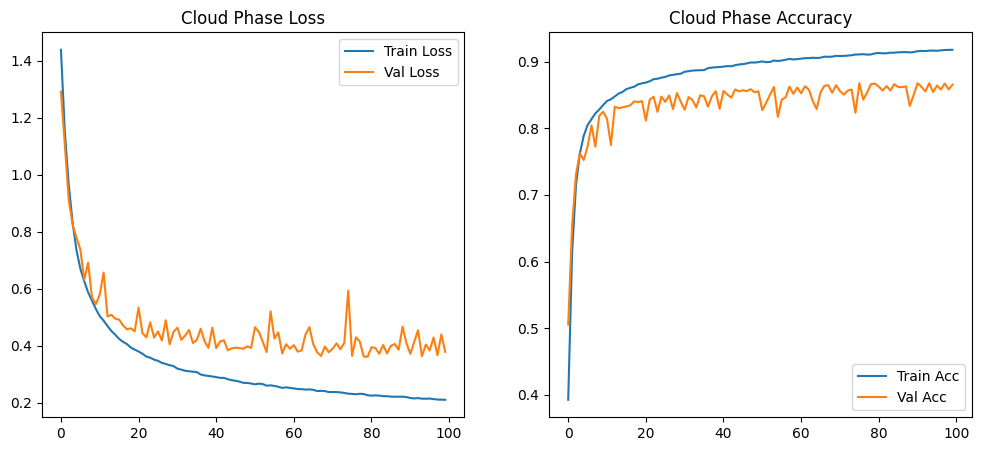

In [8]:
#PLOT LOSS and ACCURACY

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Cloud Phase Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Cloud Phase Accuracy')
plt.legend()

plt.savefig("./graphs/unet_cloud_phase.png")  

plt.show()

In [9]:
#MODEL EVALUATION

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])


report = classification_report(all_labels, all_preds, digits=3, output_dict=True)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(num_classes)])
supports = np.array([report[str(i)]['support'] for i in range(num_classes)])
iou = f1_scores / (2 - f1_scores)

print("REPORT:\n", classification_report(all_labels, all_preds, digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds))
print("\nIOU:", iou)
print("Unweighted:", np.mean(iou))
print("Weighted:", np.average(iou, weights=supports))

100%|██████████| 12/12 [00:01<00:00,  9.86it/s]


REPORT:
               precision    recall  f1-score   support

           0      0.919     0.807     0.860   4373397
           1      0.869     0.925     0.896  10864796
           2      0.773     0.808     0.790   2400565
           3      0.504     0.459     0.480    890044
           4      0.896     0.867     0.881   6014430

    accuracy                          0.861  24543232
   macro avg      0.792     0.773     0.781  24543232
weighted avg      0.862     0.861     0.860  24543232

CONFUSION MATRIX:
 [[ 3531512   760536    26631     2472    52246]
 [  271613 10044545   236471    33289   278878]
 [    3688   206405  1939628   179331    71513]
 [     494    50411   225751   408389   204999]
 [   35734   498244    80957   186826  5212669]]

IOU: [0.75380316 0.81132689 0.65299095 0.31609985 0.78716657]
Unweighted: 0.664277485955421
Weighted: 0.7617101902709087
